In [1]:
import pandas as pd 
import numpy as np
from numpy import loadtxt

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt


In [2]:
#load data
dataset = pd.read_csv("C:\\Users\\namil\\Downloads\\inputdata.csv").dropna().to_numpy()
X = dataset[:,2:7]
Y = dataset[:,9]
print(Y)

[7725.0 8730.0 10462.5 10552.5 10747.5 9397.5 9690.0 8977.5 9082.5 9832.5
 10890.0 8805.0 9817.5 8842.5 9472.5 9720.0 9607.5 8955.0 8452.5 10785.0
 10462.5 10005.0 9885.0 8055.0 11482.5 10050.0 8977.5 10627.5 9660.0
 9457.5 8542.5 9975.0]


In [38]:
#USING HYPEROPT
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#hyperparameter tuning
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180
    }

def hyperparameter_tuning(space):
    model = XGBRegressor(n_estimators =space['n_estimators'], eval_metric="rmse", max_depth = int(space['max_depth']), 
                         gamma = space['gamma'], early_stopping_rounds=10,
                         reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, verbose=False)

    pred = model.predict(X_test)
    
    arr = ((y_test - pred)/y_test)**2
    rmse= MSE(y_test, pred)**.5
    print ("SCORE:", rmse)
    #change the metric if you like
    return {'loss':rmse, 'status': STATUS_OK, 'model': model}


In [7]:
#USING RANDOMSEARCHCV
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 200, 500, 1000]}
xgbr = XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=100,
                         verbose=1)
clf.fit(X, Y)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.8999999999999999, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6}
Lowest RMSE:  719.8971827838692


In [39]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print (best)

SCORE:                                                                                                                 
571.0101368075241                                                                                                      
SCORE:                                                                                                                 
583.234029608329                                                                                                       
SCORE:                                                                                                                 
601.0279911565046                                                                                                      
SCORE:                                                                                                                 
659.6730566977565                                                                                                      
SCORE:                                  

SCORE:                                                                                                                 
598.1251321739732                                                                                                      
SCORE:                                                                                                                 
616.7541869114489                                                                                                      
SCORE:                                                                                                                 
622.5734617941062                                                                                                      
SCORE:                                                                                                                 
531.0039371059772                                                                                                      
SCORE:                                  

{'colsample_bytree': 0.9144968192551123, 'gamma': 1.3776436329160882, 'max_depth': 18.0, 'min_child_weight': 4.0, 'reg_alpha': 63.0, 'reg_lambda': 0.7216671872760884}
MAPE: 0.06910688285810386
RMSE: 737.9079452542583
RMSRE: 0.07643777604557886


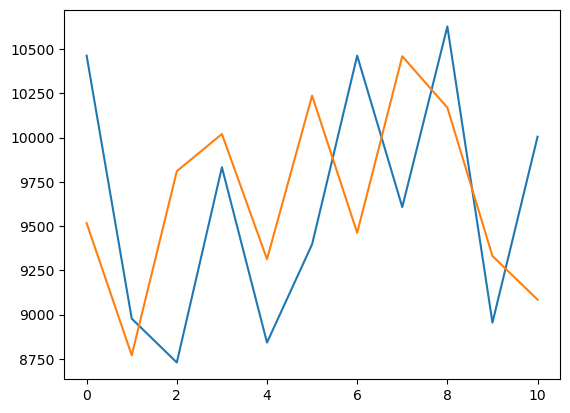

In [41]:
# tunedmodel = XGBRegressor(n_estimators=180, max_depth = 3, 
#                          gamma = 6.00990782947794, reg_alpha = 115.0, min_child_weight=0.0, 
#                          reg_lambda = 0.16628454030542197,
#                          colsample_bytree=0.9076159540289892)
print(best)
tunedmodel = XGBRegressor(n_estimators=180, max_depth = int(best['max_depth']), 
                         gamma = best['gamma'], reg_alpha = int(best['reg_alpha']),
                          min_child_weight=best['min_child_weight'], reg_lambda = best['reg_lambda'],
                         colsample_bytree=best['colsample_bytree'])

tunedmodel.fit(X_train, y_train)
prediction = tunedmodel.predict(X_test)

#package error calculations
mape = MAPE(y_test, prediction)
print("MAPE:", mape)
mse = MSE(y_test, prediction)
rmse = mse**0.5
print("RMSE:", rmse)

plt.plot(y_test)
plt.plot(prediction)

#sicong's normalized rmse
arr = ((y_test - prediction)/y_test)**2
rmsre = (np.average(arr))**.5
print("RMSRE:", rmsre)

MAPE: 0.058324677469673514
RMSE: 731.76619264268
RMSRE: 0.07557752365100591


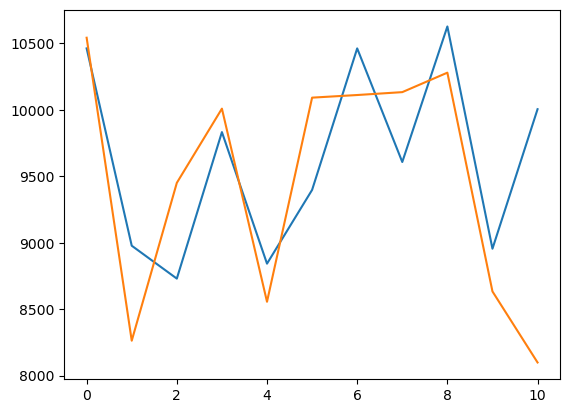

In [35]:
#with activity
X = dataset[:,2:8]
Y = dataset[:,10]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
tunedmodel.fit(X_train, y_train)
prediction = tunedmodel.predict(X_test)

#errors
mape = MAPE(y_test, prediction)
print("MAPE:", mape)
mse = MSE(y_test, prediction)
rmse = mse**0.5
print("RMSE:", rmse)

#sicong's normalized rmse
arr = ((y_test - prediction)/y_test)**2
error = (np.average(arr))**.5
print("RMSRE:", error)

plt.plot(y_test)
plt.plot(prediction)